## Download IMD gridded temperature and rainfall data
https://www.imdpune.gov.in/Clim_Pred_LRF_New/Grided_Data_Download.html

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import os
import imdlib as imd

### Temperature
#### Download

In [16]:
def download_temp_IMD(var, start, end):
    """Scrape website to download data files"""
    
    from selenium import webdriver
    from selenium.webdriver.support.ui import Select
    from selenium.webdriver.common.by import By
    from webdriver_manager.chrome import ChromeDriverManager
    import time

    if var == 'tmax':
        j = 3
        v = 'maxtemp'
    elif var == 'tmin':
        j = 4
        v = 'mintemp'
    
    options = webdriver.ChromeOptions() ;
    prefs = {"download.default_directory" : "./%s"%var};
    #example: prefs = {"download.default_directory" : "C:\Tutorial\down"};
    options.add_experimental_option("prefs", prefs);
    
    driver = webdriver.Chrome(ChromeDriverManager().install(), chrome_options=options)

    for year in range(start, end+1):

        driver.get("https://www.imdpune.gov.in/Clim_Pred_LRF_New/Grided_Data_Download.html")

        classes = driver.find_elements(By.CLASS_NAME, value='form-inline')

        temp_class = classes[j]

        e = temp_class.find_element(by='id', value=v)
        select = Select(e)
        select.select_by_visible_text('%d'%year)

        d = temp_class.find_elements(By.XPATH, "//form[@name='rain']//input[@class='btn btn-success']")[j-2]
        d.click()


    time.sleep(60)            

    driver.quit()

In [17]:
# download_temp_IMD(var='tmax', start=1951, end=2020)
# download_temp_IMD(var='tmin', start=1951, end=2020)

#### Rename files

In [18]:
base = './tmax/csv'
for file in os.listdir(base):
#     print(file)
    os.rename('%s%s'%(base, file), '%s%s.GRD'%(base, file.split('.')[0][-4:]))

base = './tmin/csv'
for file in os.listdir(base):
#     print(file)
    os.rename('%s%s'%(base, file), '%s%s.GRD'%(base, file.split('.')[0][-4:]))

#### Convert to csv

In [23]:
def convert_IMD(var, start, end):
    """
    # you should be connected to internet for downloading the data
    #-9999 value is for no data in saved csv file
    # This code will convert the IMD gridded data to csv file
    if you have data already downloaded then create folder named rain/tmax/tmin inside any folder and
    copy yearly data files in the respective folder and rename yearly data file as year name i.e 1951.GRD 1952.GRD etc and
    comment the line imd.get_data(variable,start_yr) and run the code it will convert the binary .GRD data into csv file
    """
    start_yr = start # give starting year from which you want to download/convert data: 1901 ownwards for rainfall, 1951 for tmax and tmin
    end_yr = end # give ending year upto which you want to download/convert data
    variable = var # give variable name (rain for rainfall at 0.25 deg, tmax or tmin for rainfall, min or max temperature at 1 deg resolution)
    file_format = 'yearwise' # other option (None), which will assume deafult imd naming convention
    file_dir = './%s/grd/'%var # this path should be same as mentioned in previous line
    data = imd.open_data(variable, start_yr, end_yr,'yearwise', file_dir) # this will open the data downloaded and saved in the location mentioned in previous line
    if variable == 'rain':
        grid_size = 0.25 # grid spacing in deg
        y_count = 129 # no of grids in y direction
        x_count = 135 # no of grids in x direction
        x = 66.5 # starting longitude taken from control file (.ctl)
        y = 6.5 # starting latitude taken from control file (.ctl)
    elif variable == 'tmax' or variable == 'tmin':
        grid_size = 1 # grid spacing in deg
        y_count = 31 # no of grids in y direction
        x_count = 31 # no of grids in x direction
        x = 67.5 # starting longitude taken from control file (.ctl)
        y = 7.5 # starting latitude taken from control file (.ctl)

    #print(grid_size,x_count, y_count, x, y)
    data
    data.shape
    np_array = data.data
    #print(np_array[0,0,0])
    #xr_objecct = data.get_xarray()
    #type(xr_objecct)
    #xr_objecct.mean('time').plot()
    years_no = (end_yr - start_yr) + 1
    #print(years_no)
    day = 0
    for yr in range(0,years_no):
        f = open("./%s/csv/%s_%s.csv"%(var, var, start_yr+yr),'w') # just change the path where you want to save csv file
        if ((start_yr+yr) % 4 == 0) and ((start_yr+yr) % 100 != 0):  # check for leap year
            days = 366
            count = yr + days
        elif ((start_yr+yr) % 4 == 0) and ((start_yr+yr) % 100 == 0) and ((start_yr+yr) % 400 == 0):
            days = 366
            count = yr + days
        else:
            days = 365
            count = yr + days

        day = day + days

        f.write("X,Y,")
        for d in range(0, days):
            f.write(str(d+1))
            f.write(",")
        f.write("\n")
        #print(np_array[364,0,0])
        for j in range(0, y_count):

            for i in range(0, x_count):

                f.write(str((i * grid_size) + x))
                f.write(",")
                f.write(str((j * grid_size) + y))
                f.write(",")
                time = 0
                for k in range(day-days, day):

                    val = np_array[k,i,j]
                    if val == 99.9000015258789 or val == -999:
                        f.write(str(-9999))
                        f.write(",")
                    else:
                        f.write(str(val))
                        f.write(",")


                f.write("\n")
        print("File for " + str(start_yr + yr) + "_" + str(variable) + " is saved")
    print("CSV conversion successful !")

In [24]:
convert_IMD('tmin', 1951, 1952)

(731, 31, 31)
File for 1951_tmin is saved
File for 1952_tmin is saved
CSV conversion successful !


In [8]:
df = pd.read_csv('./IMD_data2004_tmax.csv')
df.head()

,X,Y,1,2,3,4,5,6,7,8,...,358,359,360,361,362,363,364,365,366,Unnamed: 368
0,67.5,7.5,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,...,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,NaN
1,68.5,7.5,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,...,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,NaN
2,69.5,7.5,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,...,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,NaN
3,70.5,7.5,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,...,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,NaN
4,71.5,7.5,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,...,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,NaN


In [9]:
df = df.set_index(['X', 'Y'])

In [10]:
ds = df.stack().to_xarray()
ds = ds.to_dataset(name='tmax')
ds = ds.rename_dims({'X':'lon', 'Y':'lat', 'level_2':'time'})
ds = ds.rename({'X':'lon', 'Y':'lat', 'level_2':'time'})
ds['time'] = [pd.to_datetime('2004-01-01') + pd.to_timedelta(int(x)-1, 'D') for x in ds.time]
ds = ds.where(ds['tmax'] != -9999., np.nan)
ds = ds.transpose()

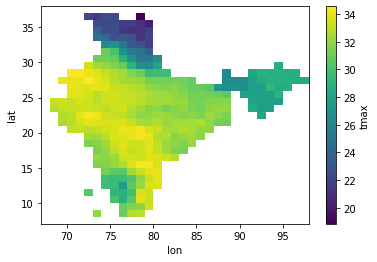

In [9]:
ds.mean('time').tmax.plot()

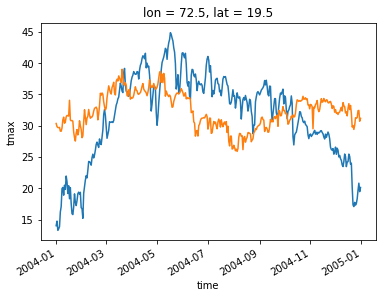

In [10]:
ds.sel(lat=28.7, lon=77, method='nearest').tmax.plot()
ds.sel(lat=19.0, lon=72.9, method='nearest').tmax.plot()

In [ ]:
driver = webdriver.Chrome(ChromeDriverManager().install(), chrome_options=options)

for year in range(2005, 2022):

    driver.get("https://www.imdpune.gov.in/Clim_Pred_LRF_New/Grided_Data_Download.html")

    classes = driver.find_elements(By.CLASS_NAME, value='form-inline')

    for i in classes:
        if i.get_attribute('name') == 'RF25':

            e = i.find_element(by='id', value='RF25')
            select = Select(e)
            select.select_by_visible_text('%d'%year)

            d = i.find_element(By.XPATH, "//form[@name='RF25']//input[@class='btn btn-success']")
            d.click()

time.sleep(60)            
            
driver.quit()

In [12]:
def preprocess(ds):
    
    if 'RAINFALL' in list(ds.var()):
        ds = ds.RAINFALL
    elif 'rainfall' in list(ds.var()):
        ds = ds.rainfall
    
    if 'LATITUDE' in ds.coords:
#         ds = ds.rename_dims({'TIME':'time', 'LATITUDE':'lat', 'LONGITUDE':'lon'})
        ds = ds.rename({'TIME':'time', 'LONGITUDE':'lon', 'LATITUDE':'lat'})    
#     print(ds.time.values[-1])
    return ds

In [ ]:
ds

In [15]:
ds = xr.open_mfdataset('./rain/*', preprocess=preprocess)
ds = ds.RAINFALL
ds

<xarray.DataArray 'RAINFALL' (time: 36890, lat: 129, lon: 135)>
dask.array<concatenate, shape=(36890, 129, 135), dtype=float64, chunksize=(366, 129, 135), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 66.5 66.75 67.0 67.25 67.5 ... 99.25 99.5 99.75 100.0
  * lat      (lat) float64 6.5 6.75 7.0 7.25 7.5 ... 37.5 37.75 38.0 38.25 38.5
  * time     (time) datetime64[ns] 1901-01-01 1901-01-02 ... 2001-12-31
Attributes:
    long_name:  Rainfall
    units:      mm
    history:    From ind1901_rfp25.grd

In [16]:
ts = ds.sel(lon=77, lat=28.7, method='nearest')
ts

<xarray.DataArray 'RAINFALL' (time: 36890)>
dask.array<getitem, shape=(36890,), dtype=float64, chunksize=(366,), chunktype=numpy.ndarray>
Coordinates:
    lon      float64 77.0
    lat      float64 28.75
  * time     (time) datetime64[ns] 1901-01-01 1901-01-02 ... 2001-12-31
Attributes:
    long_name:  Rainfall
    units:      mm
    history:    From ind1901_rfp25.grd

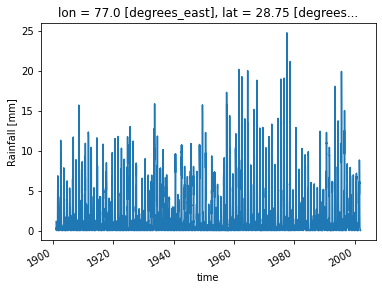

In [17]:
ts.rolling(time=28).mean().plot()

In [18]:
diff = ds.sel(time=pd.date_range('1901-01-01', '1931-01-01')).mean('time') - ds.sel(time=pd.date_range('1970-01-01', '2000-01-01')).mean('time')

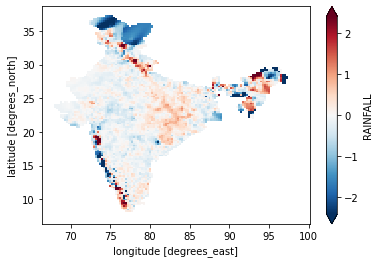

In [19]:
diff.plot(robust=True)